# Explore Concepts needed for Lighting Controller

In [1]:
%matplotlib inline

import csv
from numpy.polynomial import Polynomial
from IPython.display import display
from pprint import pp

import numpy as np
np.set_printoptions(precision=3, suppress=True)

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 300

import matplotlib.pyplot as plt

from model_helper import *
from display_helper import *

# Distance related data

In [2]:
# Set the file name of the calibration file
CALIBRATION_FILEN = 'calibration_params.csv'

# Distance measured by the sensors when no one is present
baseline_distance = None

# Depth (Entrance, Midway, Exit), Side (Right, Center, Left)
calibrated_positions = {
    'Entrance': { 'Left': None, 'Center': None, 'Right': None },
    'Midway':   { 'Left': None, 'Center': None, 'Right': None },
    'Exit':     { 'Left': None, 'Center': None, 'Right': None },
}

normalizing_poly = None

# Distance related functions

In [3]:
def _save_calibration_parameters( baseline_dist=None, calib_pos=None):
    """
    Save the baseline distance and calibrated positions data to a file
    """
    
    logging.info(f"Saving baseline distance and calibrated parameters: {CALIBRATION_FILEN}")
    with open(CALIBRATION_FILEN, mode='w', newline='') as c_file:
        c_writer = csv.writer( c_file, delimiter=',')

        # Save baseline distance value
        c_writer.writerow( [baseline_dist] )

        # Save calibrated positions values
        for depth in ['Entrance', 'Midway', 'Exit']:
            c_writer.writerow( [ calib_pos[depth][side] for side in ['Left', 'Center', 'Right'] ] )

    logging.info(f"Save completed.")


def _load_calibration_parameters():
    """
    Load the baseline distance and calibrated positions data from a file
    """
    
    logging.info(f"Loading baseline distance and calibrated parameters: {CALIBRATION_FILEN}")
    with open(CALIBRATION_FILEN, mode='r', newline='') as c_file:
        c_reader = csv.reader( c_file, delimiter=',')

        # Load baseline distance values
        baseline_dist = next(c_reader)
        try:
            baseline_dist = float(baseline_dist[0])

        except (ValueError, TypeError):
            baseline_dist = None

        # Save calibrated positions values
        calib_pos = {}
        for depth in ['Entrance', 'Midway', 'Exit']:
            calib_pos[depth] = {}
            calib_pos[depth]['Left'], calib_pos[depth]['Center'], calib_pos[depth]['Right'] = [ float(m) for m in next(c_reader) ]

    logging.info(f"Load completed.")

    return baseline_dist, calib_pos


def _calc_normalizing_poly() -> tuple:
    """
    Fit the calibrated positions data to a polynomial (linear) for distance.
    This will allow distance from Entrance to Midway to Exit to be mapped to a value 1.0 to 0.5 to 0.0 (approximately).
    """

    # Use Calibrated Position measurements that are more in line with each distance sensor:
    # NOTE: Right sensor no longer available, so only left sensor will be used in calcs

    # Build a set of x,y points to be fitted for this sensor
    x_list = []
    y_list = []
    for side in [ 'Center' ]:
        x = [ calibrated_positions[depth][side] for depth in ['Entrance', 'Midway'] ]
        y = [ 1.0, 0.5 ]
        x_list.extend(x)
        y_list.extend(y)

    # Find the maximum distance measured at the Entrance or Midway
    # and use it as the upper limit for unnormalized distance values
    x_max = max(x_list)

    # Find the coefficients of a linear equation that best fit the x,y for this sensor
    poly = Polynomial.fit( x_list, y_list, deg=1, domain=[0.0, x_max], window=[0.0, 1.0] )

    return poly
    

def normalize_distance( d:float=None ) -> float:
    """
    Generate normalized distance by applying the linear equation
    fitted to the calibrated positions measurements
    """
    # Normalized distance for distance sensors
    # Raw distance is mapped to Entrance 1.0 -> Midway 0.5 -> Exit 0.0
    return normalizing_poly.convert().coef[0] + normalizing_poly.convert().coef[1] * d



In [4]:
# Load calibration parameters if the parameters are not already set
baseline_distance, calibrated_positions = _load_calibration_parameters()
pp(baseline_distance)
pp(calibrated_positions)

103.18694114685059
{'Entrance': {'Left': 58.50367546081543,
              'Center': 31.762409210205078,
              'Right': 103.96791696548462},
 'Midway': {'Left': 13.853120803833008,
            'Center': 14.605474472045898,
            'Right': 19.516217708587646},
 'Exit': {'Left': 59.403228759765625,
          'Center': 103.10925245285034,
          'Right': 58.48731994628906}}


In [5]:

# Calculate distance normalizing polynomial, such that distance is normalized
# the calibrated positions for Entrance to Exit are normalized to 1.0 to 0.0
normalizing_poly = _calc_normalizing_poly()

In [6]:
TEST_DISTANCES = np.arange(60.0, -10.0, -5.0)
for d in TEST_DISTANCES:
    nd = normalize_distance(d)
    print(f"Distance {d:.2f} => Normalized {nd:.2f}")

Distance 60.00 => Normalized 1.82
Distance 55.00 => Normalized 1.68
Distance 50.00 => Normalized 1.53
Distance 45.00 => Normalized 1.39
Distance 40.00 => Normalized 1.24
Distance 35.00 => Normalized 1.09
Distance 30.00 => Normalized 0.95
Distance 25.00 => Normalized 0.80
Distance 20.00 => Normalized 0.66
Distance 15.00 => Normalized 0.51
Distance 10.00 => Normalized 0.37
Distance 5.00 => Normalized 0.22
Distance 0.00 => Normalized 0.07
Distance -5.00 => Normalized -0.07


In [7]:
# Path
SHORT_PATH_LIST = [
    40, 39, 35, 34, 32, 30, 30, 30, 30, 29,
    28, 27, 26, 25, 24, 23, 23, 23, 23, 23,
    22, 21, 20, 19, 14, 12, 11, 8, 8, 8, 8,
    7, 6, 5, 4, 3, 2, 1
    ]
SHORT_PATH_LIST = [ float(d) for d in SHORT_PATH_LIST ]

LONGER_PATH_LIST = []
for d in SHORT_PATH_LIST:
    LONGER_PATH_LIST.extend( [d]*10 )
print(f"Short List: {len(SHORT_PATH_LIST)}, Long List: {len(LONGER_PATH_LIST)}")

Short List: 38, Long List: 380


In [8]:
PATH_LIST = LONGER_PATH_LIST
N_PATH_LIST = len(PATH_LIST)
print(f"Path List: {N_PATH_LIST}")
# print(PATH_LIST)

# Rolling average distance
rng = np.random.default_rng(seed=1234)
dist_list = rng.normal( loc=PATH_LIST, scale=1.0 )
# print(dist_list)

# Time @ 50ms per timestep
SECS_PER_TIMESTEP = 0.05
time_list =  SECS_PER_TIMESTEP * np.arange( N_PATH_LIST )
# print(time_list)

# d_df = pd.DataFrame( {'Time':time_list, 'Path':PATH_LIST, 'Dist':dist_list} )
# d_df.plot(x='Time', y=['Dist'] )

Path List: 380


<AxesSubplot:xlabel='Time'>

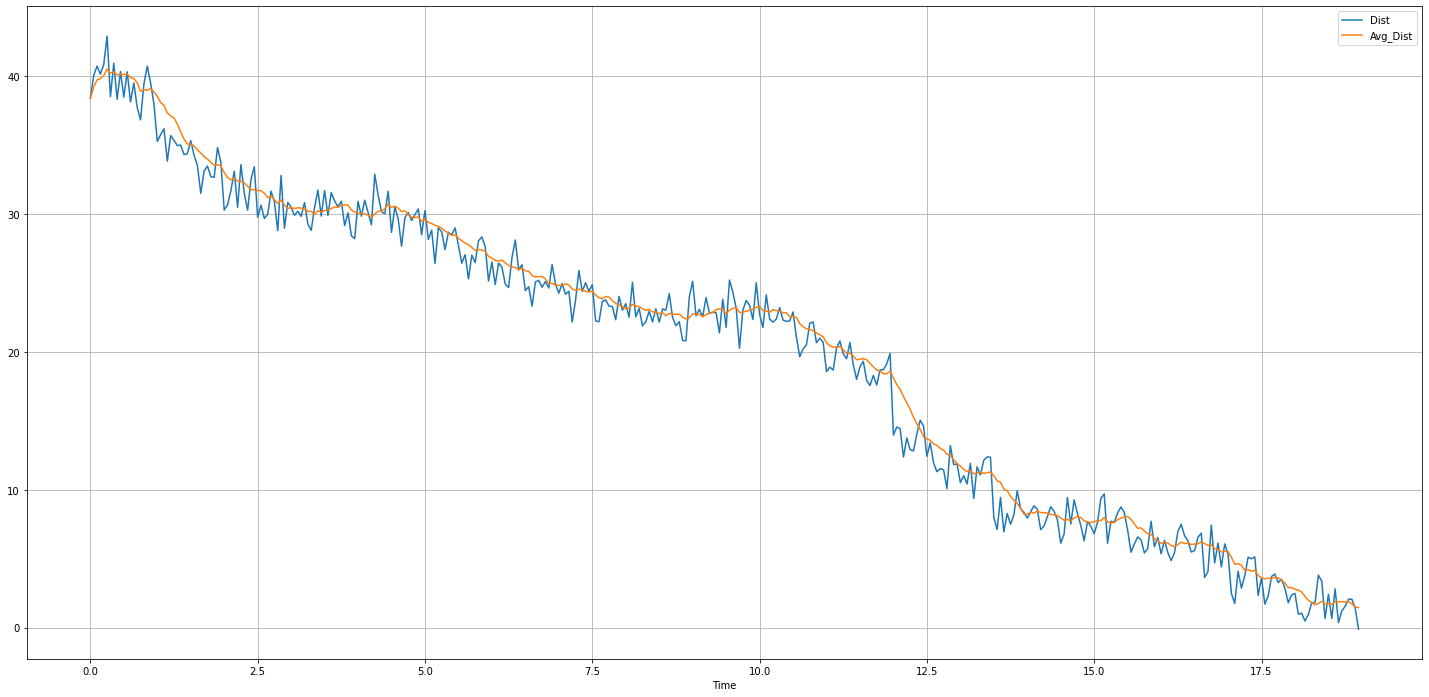

In [9]:
dist_rolling = []
# Function to calculate rolling distance measurements
def _rolling_average( d:float=None ) -> float:
    """
    Calculate the rolling average of the distance values that have been provided
    """
    
    # N_TARGET
    N_TARGET = 10

    # Accumulate values until the target number of values reached
    if len(dist_rolling) >= N_TARGET:

        # Remove the oldest value
        _ = dist_rolling.pop(0)

    # Add the new value
    dist_rolling.append(d)

    # Calculate the average
    dist_avg = np.mean(dist_rolling)

    return dist_avg

# Reinitialize the rolling distance list
dist_rolling = []

# Step through each timestep and provide a distnce value
avg_dist_list = []
for t in range( N_PATH_LIST ):
    avg_dist_list.append( _rolling_average( dist_list[t] ) )


# Plot the results
d_df = pd.DataFrame( {'Time':time_list, 'Path':PATH_LIST, 'Dist':dist_list, 'Avg_Dist':avg_dist_list } )
d_df.plot(x='Time', y=['Dist', 'Avg_Dist'], grid=True, figsize=(25,12) )    

In [10]:
full_day_secs = 24*60*60
full_day_secs

86400

In [13]:
secs_per_timestep = 0.05
full_day_count = int(full_day_secs / secs_per_timestep)
full_day_count


1728000

In [16]:
sys.maxsize / full_day_secs

106751991167300.64

[0, 0, 0, 0, 0]